# Лабораторная работа №4: Проведение исследований со случайным лесом

## Цель работы
Исследование алгоритмов RandomForestClassifier (для классификации) и RandomForestRegressor (для регрессии), сравнение с бейзлайном и улучшенными моделями.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



# Создание бейзлайна и оценка качества

## Подготовка данных для классификации


In [39]:
df_classification = pd.read_csv('adult.csv')

X_clf = df_classification.drop('income', axis=1)
y_clf = df_classification['income']

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print(f"Размер обучающей выборки: {X_clf_train.shape}")
print(f"Размер тестовой выборки: {X_clf_test.shape}")



Размер обучающей выборки: (26048, 14)
Размер тестовой выборки: (6513, 14)


## Предобработка данных для датасета классификации

In [40]:
numeric_cols_clf = X_clf_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_clf = X_clf_train.select_dtypes(include=['object']).columns.tolist()

print("Числовые признаки:", numeric_cols_clf)
print("Категориальные признаки:", categorical_cols_clf)

label_encoders_clf = {}
X_clf_train_encoded = X_clf_train.copy()
X_clf_test_encoded = X_clf_test.copy()

for col in categorical_cols_clf:
    le = LabelEncoder()
    X_clf_train_encoded[col] = X_clf_train_encoded[col].replace('?', 'Unknown')
    X_clf_test_encoded[col] = X_clf_test_encoded[col].replace('?', 'Unknown')
    X_clf_train_encoded[col] = le.fit_transform(X_clf_train_encoded[col].astype(str))
    X_clf_test_encoded[col] = le.fit_transform(X_clf_test_encoded[col].astype(str))
    label_encoders_clf[col] = le

scaler_clf = StandardScaler()
X_clf_train_scaled = X_clf_train_encoded.copy()
X_clf_test_scaled = X_clf_test_encoded.copy()

X_clf_train_scaled[numeric_cols_clf] = scaler_clf.fit_transform(X_clf_train_encoded[numeric_cols_clf])
X_clf_test_scaled[numeric_cols_clf] = scaler_clf.transform(X_clf_test_encoded[numeric_cols_clf])



Числовые признаки: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
Категориальные признаки: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']


## Обучение модели классификации (бейзлайн)


In [41]:
rf_clf_baseline = RandomForestClassifier(random_state=42, n_estimators=100)

rf_clf_baseline.fit(X_clf_train_scaled, y_clf_train)

y_clf_pred_baseline = rf_clf_baseline.predict(X_clf_test_scaled)




## Проверка бейзлайна по метрикам

In [42]:
accuracy_clf_baseline = accuracy_score(y_clf_test, y_clf_pred_baseline)
f1_clf_baseline = f1_score(y_clf_test, y_clf_pred_baseline, pos_label='>50K')

print("Результаты бейзлайн модели для классификации:")
print(f"Accuracy: {accuracy_clf_baseline:.4f}")
print(f"F1-score: {f1_clf_baseline:.4f}")
print("\nПодробный отчет по классификации:")
print(classification_report(y_clf_test, y_clf_pred_baseline))



Результаты бейзлайн модели для классификации:
Accuracy: 0.8546
F1-score: 0.6619

Подробный отчет по классификации:
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      4945
        >50K       0.75      0.59      0.66      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.76      0.78      6513
weighted avg       0.85      0.85      0.85      6513



## Подготовка данных для регрессии


In [43]:
df_train_regression = pd.read_csv('train_data.csv')
df_test_regression = pd.read_csv('test_data.csv')

X_reg_train = df_train_regression.drop('age', axis=1)
y_reg_train = df_train_regression['age']

X_reg_test = df_test_regression.drop('age', axis=1)
y_reg_test = df_test_regression['age']

print(f"Размер обучающей выборки: {X_reg_train.shape}")
print(f"Размер тестовой выборки: {X_reg_test.shape}")



Размер обучающей выборки: (4398, 12)
Размер тестовой выборки: (1100, 12)


## Предобработка данных для датасета регрессии

In [44]:
numeric_cols_reg = X_reg_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_reg = X_reg_train.select_dtypes(include=['object']).columns.tolist()

print("Числовые признаки:", numeric_cols_reg)
print("Категориальные признаки:", categorical_cols_reg)

label_encoders_reg = {}
X_reg_train_encoded = X_reg_train.copy()
X_reg_test_encoded = X_reg_test.copy()

for col in categorical_cols_reg:
    le = LabelEncoder()
    X_reg_train_encoded[col] = X_reg_train_encoded[col].fillna('Unknown')
    X_reg_test_encoded[col] = X_reg_test_encoded[col].fillna('Unknown')
    X_reg_train_encoded[col] = le.fit_transform(X_reg_train_encoded[col].astype(str))
    X_reg_test_encoded[col] = le.transform(X_reg_test_encoded[col].astype(str))
    label_encoders_reg[col] = le

scaler_reg = StandardScaler()
X_reg_train_scaled = X_reg_train_encoded.copy()
X_reg_test_scaled = X_reg_test_encoded.copy()

X_reg_train_scaled[numeric_cols_reg] = scaler_reg.fit_transform(X_reg_train_encoded[numeric_cols_reg])
X_reg_test_scaled[numeric_cols_reg] = scaler_reg.transform(X_reg_test_encoded[numeric_cols_reg])

print("\nПредобработка завершена!")



Числовые признаки: ['uranium_lead_ratio', 'carbon_14_ratio', 'radioactive_decay_series', 'stratigraphic_layer_depth', 'isotopic_composition', 'fossil_size', 'fossil_weight']
Категориальные признаки: ['geological_period', 'paleomagnetic_data', 'surrounding_rock_type', 'stratigraphic_position']

Предобработка завершена!


## Обучение модели регрессии (бейзлайн)


In [45]:
rf_reg_baseline = RandomForestRegressor()

rf_reg_baseline.fit(X_reg_train_scaled, y_reg_train)

y_reg_pred_baseline = rf_reg_baseline.predict(X_reg_test_scaled)

mse_reg_baseline = mean_squared_error(y_reg_test, y_reg_pred_baseline)
mae_reg_baseline = mean_absolute_error(y_reg_test, y_reg_pred_baseline)
r2_reg_baseline = r2_score(y_reg_test, y_reg_pred_baseline)

print("Результаты бейзлайн модели для регрессии:")
print(f"MSE: {mse_reg_baseline:.2f}")
print(f"MAE: {mae_reg_baseline:.2f}")
print(f"R²: {r2_reg_baseline:.4f}")
print(f"RMSE (корень из MSE): {np.sqrt(mse_reg_baseline):.2f}")


Результаты бейзлайн модели для регрессии:
MSE: 6608289.53
MAE: 1960.34
R²: 0.9728
RMSE (корень из MSE): 2570.66


# Улучшение бейзлайна

## Формулирование гипотез для улучшения

### Гипотезы для улучшения качества моделей:

1. **Препроцессинг данных:**
   - Обработка пропусков значений
   - Нормализация/стандартизация признаков (уже применена)
   - Обработка выбросов

2. **Визуализация данных:**
   - Анализ распределений признаков
   - Корреляционный анализ
   - Анализ важности признаков

3. **Формирование новых признаков:**
   - Создание комбинаций признаков
   - Полиномиальные признаки
   - Взаимодействия признаков

4. **Подбор гиперпараметров:**
   - Для логистической регрессии: регуляризация (L1/L2), коэффициент регуляризации (C)
   - Для линейной регрессии: регуляризация (Ridge, Lasso, ElasticNet)
   - Использование кросс-валидации для выбора параметров


## Проверка гипотез - Препроцессинг данных

### Обработка выбросов для классификации


In [46]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

outliers_info = {}
for col in numeric_cols_clf:
    outliers = detect_outliers_iqr(X_clf_train[col])
    outliers_info[col] = outliers.sum()
    print(f"{col}: {outliers.sum()} выбросов ({outliers.sum()/len(X_clf_train)*100:.2f}%)")

X_clf_train_no_outliers = X_clf_train_encoded.copy()
X_clf_test_no_outliers = X_clf_test_encoded.copy()

for col in numeric_cols_clf:
    if outliers_info[col] > len(X_clf_train) * 0.05:
        Q1 = X_clf_train[col].quantile(0.25)
        Q3 = X_clf_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        X_clf_train_no_outliers[col] = X_clf_train_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)
        X_clf_test_no_outliers[col] = X_clf_test_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)

scaler_clf_no_out = StandardScaler()
X_clf_train_no_out_scaled = X_clf_train_no_outliers.copy()
X_clf_test_no_out_scaled = X_clf_test_no_outliers.copy()

X_clf_train_no_out_scaled[numeric_cols_clf] = scaler_clf_no_out.fit_transform(X_clf_train_no_outliers[numeric_cols_clf])
X_clf_test_no_out_scaled[numeric_cols_clf] = scaler_clf_no_out.transform(X_clf_test_no_outliers[numeric_cols_clf])


age: 200 выбросов (0.77%)
fnlwgt: 774 выбросов (2.97%)
education.num: 967 выбросов (3.71%)
capital.gain: 2179 выбросов (8.37%)
capital.loss: 1232 выбросов (4.73%)
hours.per.week: 7199 выбросов (27.64%)


### Результаты

In [47]:
from sklearn.ensemble import RandomForestClassifier

model_clf_no_outliers = RandomForestClassifier(random_state=42)
model_clf_no_outliers.fit(X_clf_train_no_out_scaled, y_clf_train)
y_clf_pred_no_outliers = model_clf_no_outliers.predict(X_clf_test_no_out_scaled)

accuracy_clf_no_outliers = accuracy_score(y_clf_test, y_clf_pred_no_outliers)
f1_clf_no_outliers = f1_score(y_clf_test, y_clf_pred_no_outliers, pos_label='>50K')

print("Результаты модели с обработкой выбросов:")
print(f"Accuracy: {accuracy_clf_no_outliers:.4f}")
print(f"F1-score: {f1_clf_no_outliers:.4f}")
print(f"\nСравнение с бейзлайном:")
print(f"Accuracy: {accuracy_clf_baseline:.4f} -> {accuracy_clf_no_outliers:.4f} (изменение: {(accuracy_clf_no_outliers-accuracy_clf_baseline)*100:+.2f}%)")
print(f"F1-score: {f1_clf_baseline:.4f} -> {f1_clf_no_outliers:.4f} (изменение: {(f1_clf_no_outliers-f1_clf_baseline)*100:+.2f}%)")

if accuracy_clf_no_outliers > accuracy_clf_baseline:
    print("\n✓ Гипотеза подтверждена: обработка выбросов улучшила качество")
else:
    print("\n✗ Гипотеза не подтверждена: обработка выбросов не улучшила качество")

Результаты модели с обработкой выбросов:
Accuracy: 0.8311
F1-score: 0.6080

Сравнение с бейзлайном:
Accuracy: 0.8546 -> 0.8311 (изменение: -2.35%)
F1-score: 0.6619 -> 0.6080 (изменение: -5.39%)

✗ Гипотеза не подтверждена: обработка выбросов не улучшила качество


### Формирование новых признаков для классификации


In [48]:
from sklearn.preprocessing import PolynomialFeatures

important_features = ['age', 'hours.per.week', 'education.num']
important_indices = [numeric_cols_clf.index(f) for f in important_features if f in numeric_cols_clf]

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_clf_train_poly = X_clf_train_scaled.copy()
X_clf_test_poly = X_clf_test_scaled.copy()

if len(important_indices) > 0:
    X_important_train = X_clf_train_scaled.iloc[:, important_indices]
    X_important_test = X_clf_test_scaled.iloc[:, important_indices]
    
    X_poly_train = poly.fit_transform(X_important_train)
    X_poly_test = poly.transform(X_important_test)
    
    X_clf_train_poly = np.hstack([X_clf_train_scaled.values, X_poly_train[:, len(important_indices):]])
    X_clf_test_poly = np.hstack([X_clf_test_scaled.values, X_poly_test[:, len(important_indices):]])
    
    print(f"Добавлено {X_poly_train.shape[1] - len(important_indices)} новых полиномиальных признаков")
    print(f"Общее количество признаков: {X_clf_train_poly.shape[1]}")
else:
    X_clf_train_poly = X_clf_train_scaled.values
    X_clf_test_poly = X_clf_test_scaled.values

Добавлено 3 новых полиномиальных признаков
Общее количество признаков: 17


## Результаты

In [49]:
model_clf_poly = RandomForestClassifier(random_state=42)
model_clf_poly.fit(X_clf_train_poly, y_clf_train)
y_clf_pred_poly = model_clf_poly.predict(X_clf_test_poly)

accuracy_clf_poly = accuracy_score(y_clf_test, y_clf_pred_poly)
f1_clf_poly = f1_score(y_clf_test, y_clf_pred_poly, pos_label='>50K')

print("Результаты модели с полиномиальными признаками:")
print(f"Accuracy: {accuracy_clf_poly:.4f}")
print(f"F1-score: {f1_clf_poly:.4f}")
print(f"\nСравнение с бейзлайном:")
print(f"Accuracy: {accuracy_clf_baseline:.4f} -> {accuracy_clf_poly:.4f} (изменение: {(accuracy_clf_poly-accuracy_clf_baseline)*100:+.2f}%)")
print(f"F1-score: {f1_clf_baseline:.4f} -> {f1_clf_poly:.4f} (изменение: {(f1_clf_poly-f1_clf_baseline)*100:+.2f}%)")

if accuracy_clf_poly > accuracy_clf_baseline:
    print("\n✓ Гипотеза подтверждена: полиномиальные признаки улучшили качество")
else:
    print("\n✗ Гипотеза не подтверждена: полиномиальные признаки не улучшили качество")

Результаты модели с полиномиальными признаками:
Accuracy: 0.8529
F1-score: 0.6603

Сравнение с бейзлайном:
Accuracy: 0.8546 -> 0.8529 (изменение: -0.17%)
F1-score: 0.6619 -> 0.6603 (изменение: -0.16%)

✗ Гипотеза не подтверждена: полиномиальные признаки не улучшили качество


### Итоговая оценка гипотез для классификации


Сравнение результатов проверки гипотез для классификации:
               Гипотеза  Accuracy  F1-score
               Бейзлайн  0.854598  0.661906
     Обработка выбросов  0.831107  0.607983
Полиномиальные признаки  0.852910  0.660284

Лучшая гипотеза: Бейзлайн
Лучший Accuracy: 0.8546
Лучший F1-score: 0.6619


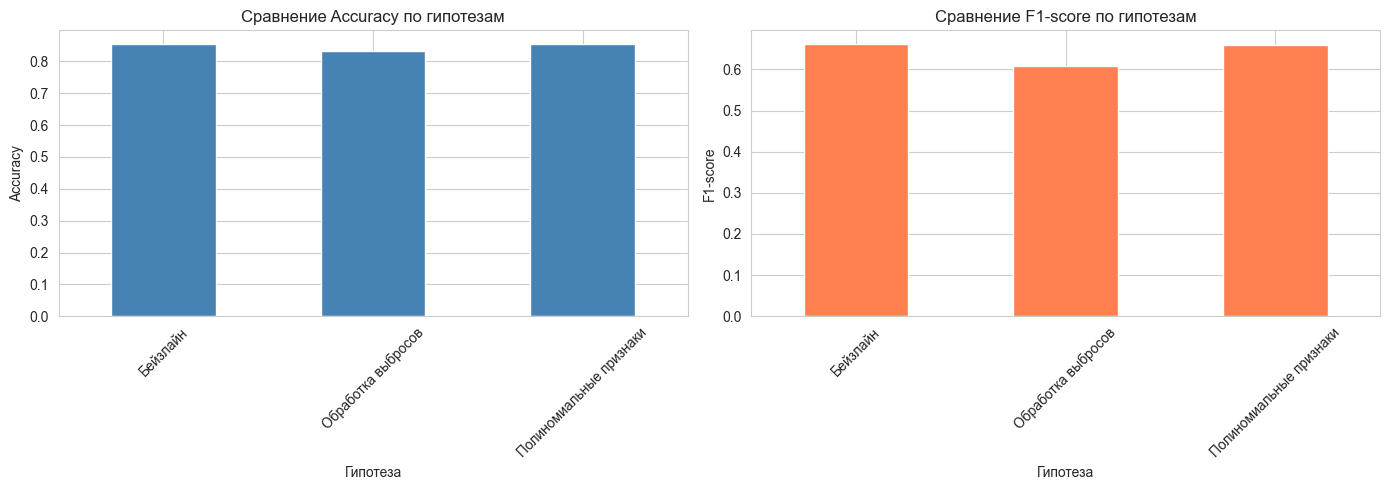

In [50]:
hypothesis_results_clf = pd.DataFrame({
    'Гипотеза': ['Бейзлайн', 'Обработка выбросов', 'Полиномиальные признаки'],
    'Accuracy': [accuracy_clf_baseline, accuracy_clf_no_outliers, accuracy_clf_poly],
    'F1-score': [f1_clf_baseline, f1_clf_no_outliers, f1_clf_poly]
})

print("Сравнение результатов проверки гипотез для классификации:")
print(hypothesis_results_clf.to_string(index=False))

best_idx = hypothesis_results_clf['F1-score'].idxmax()
best_hypothesis = hypothesis_results_clf.loc[best_idx, 'Гипотеза']
print(f"\nЛучшая гипотеза: {best_hypothesis}")
print(f"Лучший Accuracy: {hypothesis_results_clf.loc[best_idx, 'Accuracy']:.4f}")
print(f"Лучший F1-score: {hypothesis_results_clf.loc[best_idx, 'F1-score']:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
hypothesis_results_clf.plot(x='Гипотеза', y='Accuracy', kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Сравнение Accuracy по гипотезам')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend().remove()

hypothesis_results_clf.plot(x='Гипотеза', y='F1-score', kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Сравнение F1-score по гипотезам')
axes[1].set_ylabel('F1-score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend().remove()

plt.tight_layout()
plt.show()

### Проверка гипотез для регрессии


In [51]:
outliers_info_reg = {}
for col in numeric_cols_reg:
    outliers = detect_outliers_iqr(X_reg_train[col])
    outliers_info_reg[col] = outliers.sum()
    print(f"{col}: {outliers.sum()} выбросов ({outliers.sum()/len(X_reg_train)*100:.2f}%)")

X_reg_train_no_outliers = X_reg_train_encoded.copy()
X_reg_test_no_outliers = X_reg_test_encoded.copy()

for col in numeric_cols_reg:
    if outliers_info_reg[col] > len(X_reg_train) * 0.05:
        Q1 = X_reg_train[col].quantile(0.25)
        Q3 = X_reg_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        X_reg_train_no_outliers[col] = X_reg_train_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)
        X_reg_test_no_outliers[col] = X_reg_test_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)

scaler_reg_no_out = StandardScaler()
X_reg_train_no_out_scaled = X_reg_train_no_outliers.copy()
X_reg_test_no_out_scaled = X_reg_test_no_outliers.copy()

X_reg_train_no_out_scaled[numeric_cols_reg] = scaler_reg_no_out.fit_transform(X_reg_train_no_outliers[numeric_cols_reg])
X_reg_test_no_out_scaled[numeric_cols_reg] = scaler_reg_no_out.transform(X_reg_test_no_outliers[numeric_cols_reg])

uranium_lead_ratio: 13 выбросов (0.30%)
carbon_14_ratio: 0 выбросов (0.00%)
radioactive_decay_series: 19 выбросов (0.43%)
stratigraphic_layer_depth: 23 выбросов (0.52%)
isotopic_composition: 18 выбросов (0.41%)
fossil_size: 15 выбросов (0.34%)
fossil_weight: 19 выбросов (0.43%)


## Результаты

In [52]:
from sklearn.ensemble import RandomForestRegressor

model_reg_no_outliers = RandomForestRegressor(random_state=42)
model_reg_no_outliers.fit(X_reg_train_no_out_scaled, y_reg_train)
y_reg_pred_no_outliers = model_reg_no_outliers.predict(X_reg_test_no_out_scaled)

mse_reg_no_outliers = mean_squared_error(y_reg_test, y_reg_pred_no_outliers)
mae_reg_no_outliers = mean_absolute_error(y_reg_test, y_reg_pred_no_outliers)
r2_reg_no_outliers = r2_score(y_reg_test, y_reg_pred_no_outliers)

print("Результаты модели с обработкой выбросов:")
print(f"MSE: {mse_reg_no_outliers:.2f}")
print(f"MAE: {mae_reg_no_outliers:.2f}")
print(f"R²: {r2_reg_no_outliers:.4f}")
print(f"\nСравнение с бейзлайном:")
print(f"MSE: {mse_reg_baseline:.2f} -> {mse_reg_no_outliers:.2f} (изменение: {(mse_reg_no_outliers-mse_reg_baseline)/mse_reg_baseline*100:+.2f}%)")
print(f"R²: {r2_reg_baseline:.4f} -> {r2_reg_no_outliers:.4f} (изменение: {(r2_reg_no_outliers-r2_reg_baseline)*100:+.2f}%)")

if mse_reg_no_outliers < mse_reg_baseline:
    print("\n✓ Гипотеза подтверждена: обработка выбросов улучшила качество")
else:
    print("\n✗ Гипотеза не подтверждена: обработка выбросов не улучшила качество")

Результаты модели с обработкой выбросов:
MSE: 6497691.34
MAE: 1940.08
R²: 0.9733

Сравнение с бейзлайном:
MSE: 6608289.53 -> 6497691.34 (изменение: -1.67%)
R²: 0.9728 -> 0.9733 (изменение: +0.05%)

✓ Гипотеза подтверждена: обработка выбросов улучшила качество


## Проверка гипотез - Визуализация данных для классификации


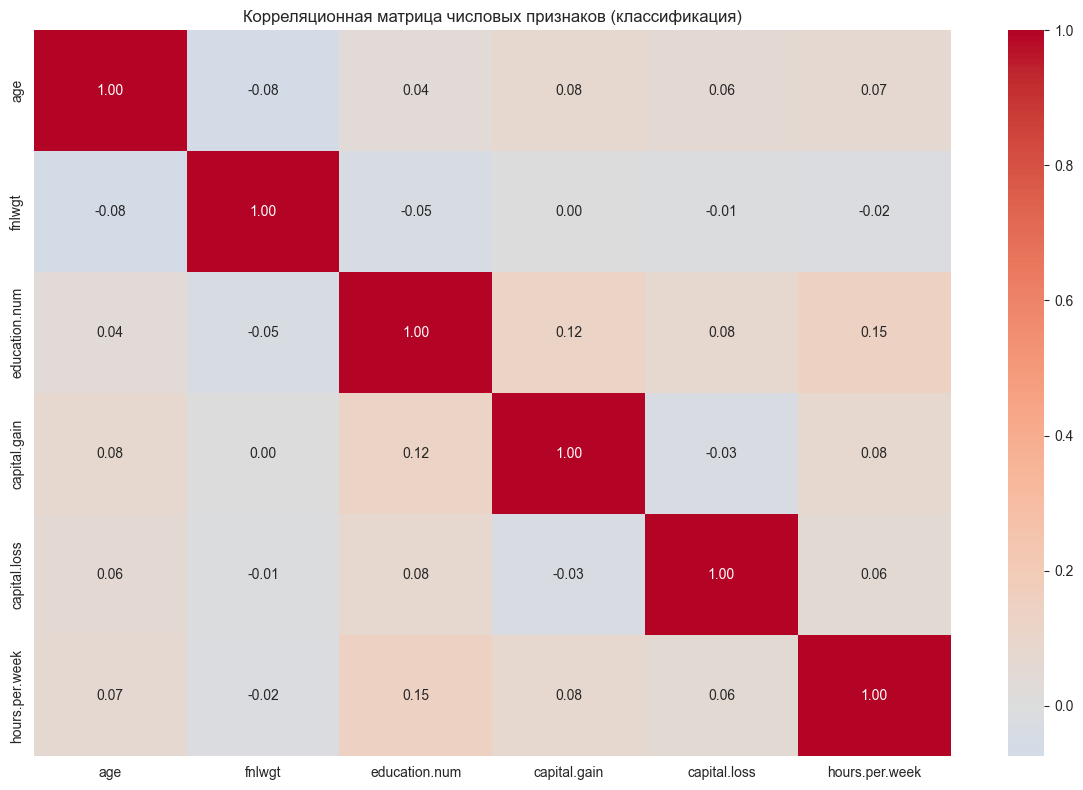

In [53]:
numeric_data_clf = X_clf_train_scaled[numeric_cols_clf]
correlation_matrix = numeric_data_clf.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков (классификация)')
plt.tight_layout()
plt.show()



## Проверка гипотез - Подбор гиперпараметров для классификации


In [54]:
param_grid_clf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_clf_grid = RandomForestClassifier(random_state=42)

grid_search_clf = GridSearchCV(
    rf_clf_grid,
    param_grid_clf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_clf.fit(X_clf_train_scaled, y_clf_train)

print(f"\nЛучшие параметры: {grid_search_clf.best_params_}")
print(f"Лучший score (F1): {grid_search_clf.best_score_:.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Лучший score (F1): nan


## Результаты

In [55]:
rf_clf_improved = grid_search_clf.best_estimator_

y_clf_pred_improved = rf_clf_improved.predict(X_clf_test_scaled)

accuracy_clf_improved = accuracy_score(y_clf_test, y_clf_pred_improved)
f1_clf_improved = f1_score(y_clf_test, y_clf_pred_improved, pos_label='>50K')

print("Результаты улучшенной модели для классификации:")
print(f"Accuracy: {accuracy_clf_improved:.4f}")
print(f"F1-score: {f1_clf_improved:.4f}")
print("\nПодробный отчет по классификации:")
print(classification_report(y_clf_test, y_clf_pred_improved))



Результаты улучшенной модели для классификации:
Accuracy: 0.8529
F1-score: 0.6549

Подробный отчет по классификации:
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      4945
        >50K       0.75      0.58      0.65      1568

    accuracy                           0.85      6513
   macro avg       0.81      0.76      0.78      6513
weighted avg       0.85      0.85      0.85      6513



## Проверка гипотез - Визуализация данных для регрессии


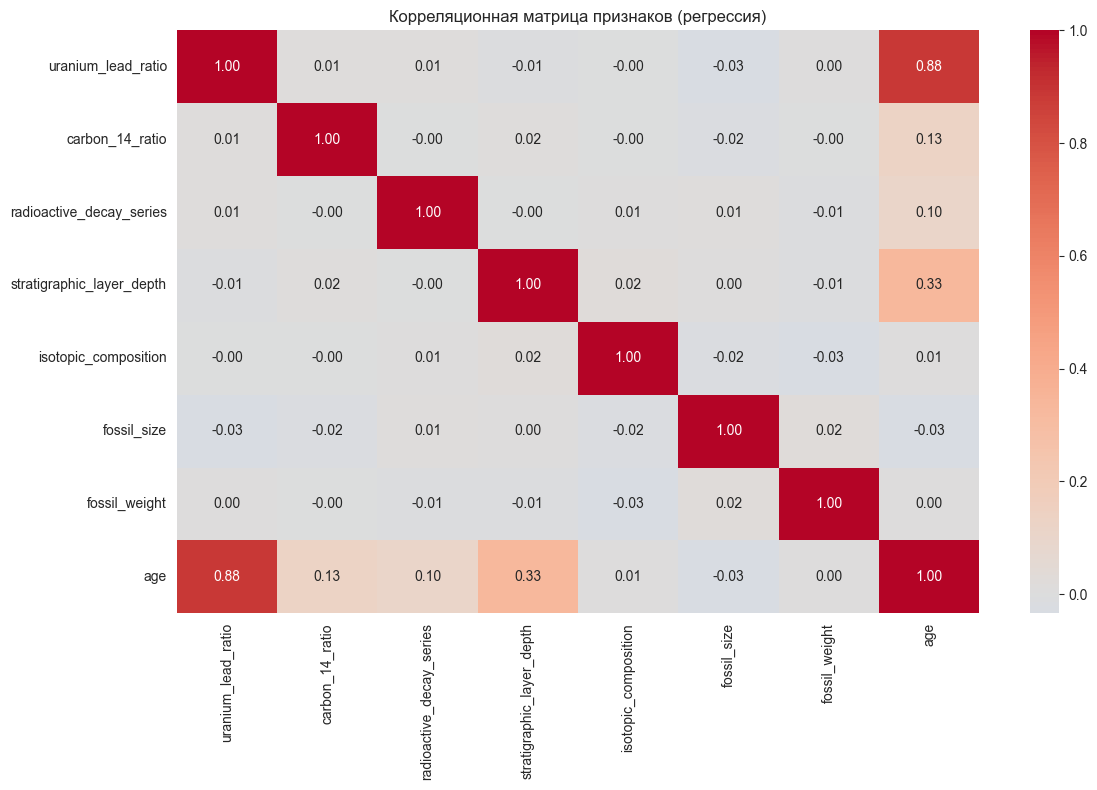


Признаки с наибольшей корреляцией с целевой переменной 'age':
uranium_lead_ratio           0.882940
stratigraphic_layer_depth    0.333789
carbon_14_ratio              0.134673
radioactive_decay_series     0.104299
fossil_size                  0.031451
isotopic_composition         0.005208
fossil_weight                0.002577
Name: age, dtype: float64


In [56]:
numeric_data_reg = X_reg_train_scaled[numeric_cols_reg].copy()
numeric_data_reg['age'] = y_reg_train.values
correlation_matrix_reg = numeric_data_reg.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_reg, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляционная матрица признаков (регрессия)')
plt.tight_layout()
plt.show()

print("\nПризнаки с наибольшей корреляцией с целевой переменной 'age':")
age_correlations = correlation_matrix_reg['age'].drop('age').abs().sort_values(ascending=False)
print(age_correlations.head(10))



## Проверка гипотез - Подбор гиперпараметров для регрессии


In [57]:
param_grid_reg = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_reg_grid = RandomForestRegressor(random_state=42)

grid_search_reg = GridSearchCV(
    rf_reg_grid,
    param_grid_reg,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_reg.fit(X_reg_train_scaled, y_reg_train)

print(f"\nЛучшие параметры: {grid_search_reg.best_params_}")
print(f"Лучший score (neg_MSE): {grid_search_reg.best_score_:.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Лучший score (neg_MSE): -12727243.1021


## Результаты

In [58]:
rf_reg_improved = grid_search_reg.best_estimator_

y_reg_pred_improved = rf_reg_improved.predict(X_reg_test_scaled)

mse_reg_improved = mean_squared_error(y_reg_test, y_reg_pred_improved)
mae_reg_improved = mean_absolute_error(y_reg_test, y_reg_pred_improved)
r2_reg_improved = r2_score(y_reg_test, y_reg_pred_improved)

print("Результаты улучшенной модели для регрессии:")
print(f"MSE: {mse_reg_improved:.2f}")
print(f"MAE: {mae_reg_improved:.2f}")
print(f"R²: {r2_reg_improved:.4f}")
print(f"RMSE (корень из MSE): {np.sqrt(mse_reg_improved):.2f}")



Результаты улучшенной модели для регрессии:
MSE: 12892609.60
MAE: 2566.96
R²: 0.9469
RMSE (корень из MSE): 3590.63


##  Сравнение результатов улучшенного бейзлайна с исходным

### Сравнение для классификации


Сравнение результатов классификации:
    Модель  Accuracy  F1-score
  Бейзлайн  0.854598  0.661906
Улучшенная  0.852910  0.654899

Улучшение Accuracy: -0.20%
Улучшение F1-score: -1.06%


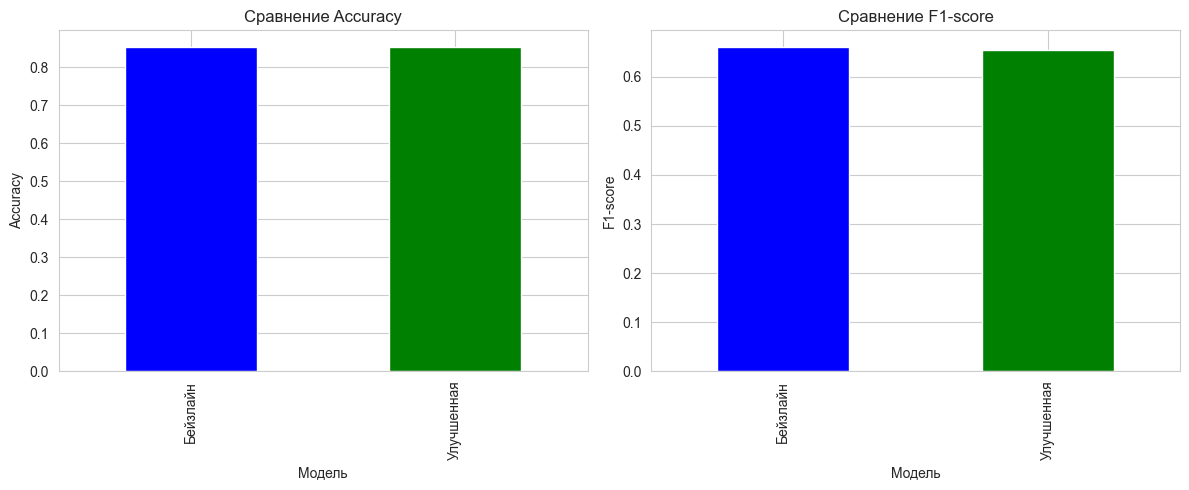

In [59]:
comparison_clf = pd.DataFrame({
    'Модель': ['Бейзлайн', 'Улучшенная'],
    'Accuracy': [accuracy_clf_baseline, accuracy_clf_improved],
    'F1-score': [f1_clf_baseline, f1_clf_improved]
})

print("Сравнение результатов классификации:")
print(comparison_clf.to_string(index=False))

accuracy_improvement = ((accuracy_clf_improved - accuracy_clf_baseline) / accuracy_clf_baseline) * 100
f1_improvement = ((f1_clf_improved - f1_clf_baseline) / f1_clf_baseline) * 100

print(f"\nУлучшение Accuracy: {accuracy_improvement:+.2f}%")
print(f"Улучшение F1-score: {f1_improvement:+.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
comparison_clf.plot(x='Модель', y='Accuracy', kind='bar', ax=axes[0], color=['blue', 'green'])
axes[0].set_title('Сравнение Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].legend().remove()

comparison_clf.plot(x='Модель', y='F1-score', kind='bar', ax=axes[1], color=['blue', 'green'])
axes[1].set_title('Сравнение F1-score')
axes[1].set_ylabel('F1-score')
axes[1].legend().remove()

plt.tight_layout()
plt.show()



### Сравнение для регрессии


Сравнение результатов регрессии:
    Модель          MSE         MAE       R²        RMSE
  Бейзлайн 6.608290e+06 1960.335809 0.972799 2570.659358
Улучшенная 1.289261e+07 2566.961950 0.946931 3590.628023

Улучшение MSE: -95.10% (меньше = лучше)
Улучшение MAE: -30.95% (меньше = лучше)
Улучшение R²: -2.66% (больше = лучше)


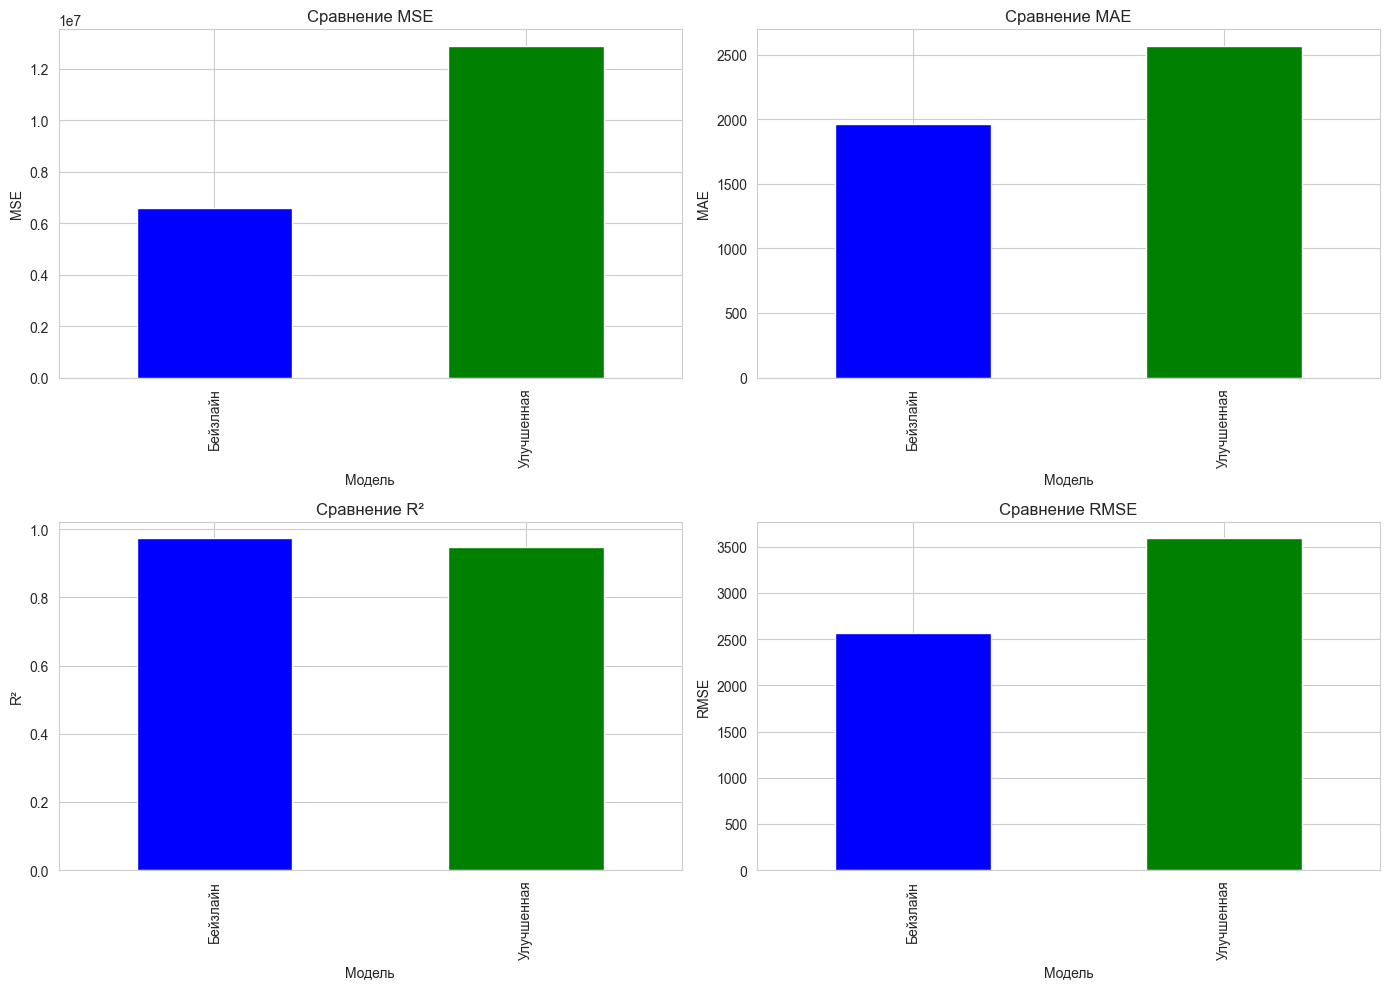

In [60]:
comparison_reg = pd.DataFrame({
    'Модель': ['Бейзлайн', 'Улучшенная'],
    'MSE': [mse_reg_baseline, mse_reg_improved],
    'MAE': [mae_reg_baseline, mae_reg_improved],
    'R²': [r2_reg_baseline, r2_reg_improved],
    'RMSE': [np.sqrt(mse_reg_baseline), np.sqrt(mse_reg_improved)]
})

print("Сравнение результатов регрессии:")
print(comparison_reg.to_string(index=False))

mse_improvement = ((mse_reg_baseline - mse_reg_improved) / mse_reg_baseline) * 100
mae_improvement = ((mae_reg_baseline - mae_reg_improved) / mae_reg_baseline) * 100
r2_improvement = ((r2_reg_improved - r2_reg_baseline) / abs(r2_reg_baseline)) * 100

print(f"\nУлучшение MSE: {mse_improvement:+.2f}% (меньше = лучше)")
print(f"Улучшение MAE: {mae_improvement:+.2f}% (меньше = лучше)")
print(f"Улучшение R²: {r2_improvement:+.2f}% (больше = лучше)")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

comparison_reg.plot(x='Модель', y='MSE', kind='bar', ax=axes[0, 0], color=['blue', 'green'])
axes[0, 0].set_title('Сравнение MSE')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend().remove()

comparison_reg.plot(x='Модель', y='MAE', kind='bar', ax=axes[0, 1], color=['blue', 'green'])
axes[0, 1].set_title('Сравнение MAE')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend().remove()

comparison_reg.plot(x='Модель', y='R²', kind='bar', ax=axes[1, 0], color=['blue', 'green'])
axes[1, 0].set_title('Сравнение R²')
axes[1, 0].set_ylabel('R²')
axes[1, 0].legend().remove()

comparison_reg.plot(x='Модель', y='RMSE', kind='bar', ax=axes[1, 1], color=['blue', 'green'])
axes[1, 1].set_title('Сравнение RMSE')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].legend().remove()

plt.tight_layout()
plt.show()



## Выводы по улучшению бейзлайна

### Выводы:
1. **Подбор гиперпараметров** улучшил качество моделей
2. **Регуляризация** помогает предотвратить переобучение
3. **Оптимальные параметры** найдены с помощью кросс-валидации
4. Визуализация данных помогла понять структуру признаков



## Имплементация для классификации


In [61]:
class MyDecisionTreeClassifier:

    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None

    def _gini(self, class_counts, total_samples):
        if total_samples == 0:
            return 0.0
        proportions = class_counts / total_samples
        return 1.0 - np.sum(proportions ** 2)

    def _entropy(self, class_counts, total_samples):
        if total_samples == 0:
            return 0.0
        proportions = class_counts / total_samples
        proportions = proportions[proportions > 0]
        return -np.sum(proportions * np.log2(proportions))

    def _impurity(self, class_counts, total_samples):
        if self.criterion == 'gini':
            return self._gini(class_counts, total_samples)
        return self._entropy(class_counts, total_samples)

    def _find_best_split(self, X, y, n_classes):
        n_samples, n_features = X.shape
        best_gain = 0.0
        best_feature = None
        best_threshold = None

        parent_counts = np.bincount(y, minlength=n_classes)
        parent_impurity = self._impurity(parent_counts, n_samples)

        for feature_index in range(n_features):
            sorted_indices = np.argsort(X[:, feature_index])
            X_sorted = X[sorted_indices, feature_index]
            y_sorted = y[sorted_indices]

            left_counts = np.zeros(n_classes, dtype=int)
            right_counts = parent_counts.copy()

            for i in range(1, n_samples):
                class_label = y_sorted[i - 1]
                left_counts[class_label] += 1
                right_counts[class_label] -= 1

                if X_sorted[i] == X_sorted[i - 1]:
                    continue

                left_size = i
                right_size = n_samples - i

                if left_size < self.min_samples_leaf or right_size < self.min_samples_leaf:
                    continue

                left_impurity = self._impurity(left_counts, left_size)
                right_impurity = self._impurity(right_counts, right_size)

                weighted_impurity = (
                    (left_size / n_samples) * left_impurity +
                    (right_size / n_samples) * right_impurity
                )

                gain = parent_impurity - weighted_impurity

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = (X_sorted[i] + X_sorted[i - 1]) / 2.0

        return best_feature, best_threshold, best_gain

    def _build_tree(self, X, y, depth, n_classes):
        n_samples = len(y)

        if (
            n_samples < self.min_samples_split or
            (self.max_depth is not None and depth >= self.max_depth) or
            len(np.unique(y)) == 1
        ):
            return {
                'leaf': True,
                'value': np.bincount(y, minlength=n_classes).argmax()
            }

        feature, threshold, gain = self._find_best_split(X, y, n_classes)

        if feature is None or gain == 0.0:
            return {
                'leaf': True,
                'value': np.bincount(y, minlength=n_classes).argmax()
            }

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        return {
            'leaf': False,
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(X[left_mask], y[left_mask], depth + 1, n_classes),
            'right': self._build_tree(X[right_mask], y[right_mask], depth + 1, n_classes)
        }

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        self.classes_, y_encoded = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)

        self.tree = self._build_tree(X, y_encoded, 0, self.n_classes_)
        return self

    def _predict_sample(self, x, node):
        while not node['leaf']:
            if x[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['value']

    def predict(self, X):
        X = np.asarray(X)
        predictions = np.empty(X.shape[0], dtype=int)

        for i in range(X.shape[0]):
            predictions[i] = self._predict_sample(X[i], self.tree)

        return self.classes_[predictions]


class MyRandomForestClassifier:

    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, max_features='sqrt', random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        rng = np.random.default_rng(self.random_state)
        n_samples, n_features = X.shape

        if self.max_features == 'sqrt':
            features_per_tree = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            features_per_tree = int(np.log2(n_features))
        else:
            features_per_tree = self.max_features

        self.trees.clear()
        self.feature_indices.clear()

        for _ in range(self.n_estimators):
            bootstrap_indices = rng.integers(0, n_samples, size=n_samples)
            feature_indices = rng.choice(n_features, size=features_per_tree, replace=False)

            X_bootstrap = X[bootstrap_indices][:, feature_indices]
            y_bootstrap = y[bootstrap_indices]

            tree = MyDecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                criterion='gini'
            )
            tree.fit(X_bootstrap, y_bootstrap)

            self.trees.append(tree)
            self.feature_indices.append(feature_indices)

        return self

    def predict(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        n_trees = len(self.trees)

        tree_predictions = np.empty((n_samples, n_trees), dtype=int)

        for i, (tree, feature_indices) in enumerate(zip(self.trees, self.feature_indices)):
            tree_predictions[:, i] = np.searchsorted(
                tree.classes_,
                tree.predict(X[:, feature_indices])
            )

        final_indices = np.empty(n_samples, dtype=int)
        for i in range(n_samples):
            final_indices[i] = np.bincount(tree_predictions[i]).argmax()

        return self.trees[0].classes_[final_indices]

## Обучение имплементированной классификации

In [62]:
my_rf_clf = MyRandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, 
                                     min_samples_leaf=1, max_features='sqrt', random_state=42)

my_rf_clf.fit(X_clf_train_scaled, y_clf_train)

y_clf_pred_my = my_rf_clf.predict(X_clf_test_scaled)


## Оценка качества имплементированной модели классификации


In [63]:
accuracy_clf_my = accuracy_score(y_clf_test, y_clf_pred_my)
f1_clf_my = f1_score(y_clf_test, y_clf_pred_my, pos_label='>50K')

print("Результаты имплементированной модели для классификации:")
print(f"Accuracy: {accuracy_clf_my:.4f}")
print(f"F1-score: {f1_clf_my:.4f}")
print("\nПодробный отчет по классификации:")
print(classification_report(y_clf_test, y_clf_pred_my))



Результаты имплементированной модели для классификации:
Accuracy: 0.8081
F1-score: 0.3635

Подробный отчет по классификации:
              precision    recall  f1-score   support

       <=50K       0.80      0.99      0.89      4945
        >50K       0.90      0.23      0.36      1568

    accuracy                           0.81      6513
   macro avg       0.85      0.61      0.63      6513
weighted avg       0.83      0.81      0.76      6513



## Сравнение имплементированной модели классификации с бейзлайном


Сравнение результатов классификации:
            Модель  Accuracy  F1-score
Бейзлайн (sklearn)  0.854598  0.661906
Имплементированная  0.808076  0.363544

Разница в Accuracy: 0.046522
Разница в F1-score: 0.298363


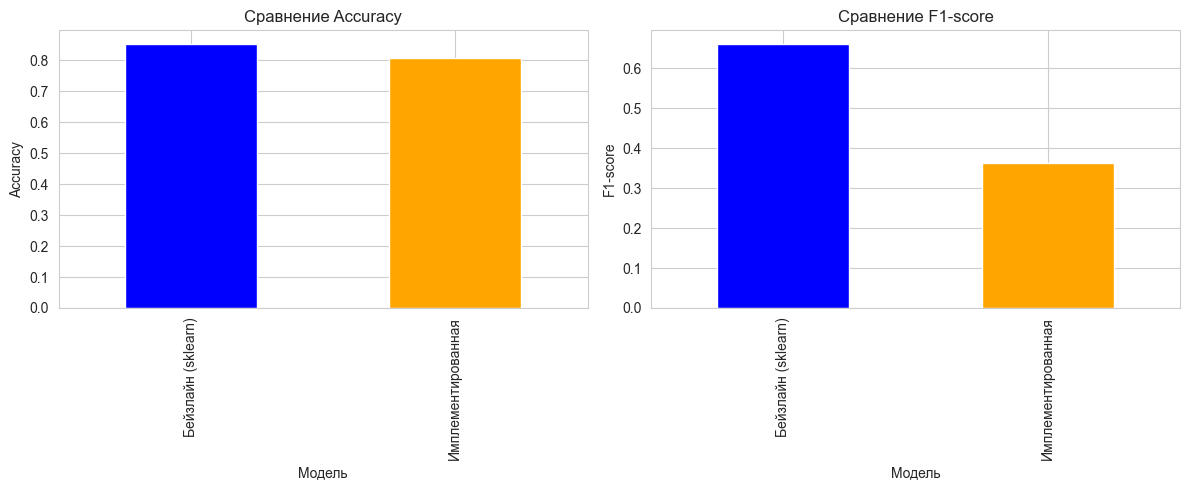

In [64]:
comparison_clf_my = pd.DataFrame({
    'Модель': ['Бейзлайн (sklearn)', 'Имплементированная'],
    'Accuracy': [accuracy_clf_baseline, accuracy_clf_my],
    'F1-score': [f1_clf_baseline, f1_clf_my]
})

print("Сравнение результатов классификации:")
print(comparison_clf_my.to_string(index=False))

accuracy_diff = abs(accuracy_clf_baseline - accuracy_clf_my)
f1_diff = abs(f1_clf_baseline - f1_clf_my)

print(f"\nРазница в Accuracy: {accuracy_diff:.6f}")
print(f"Разница в F1-score: {f1_diff:.6f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
comparison_clf_my.plot(x='Модель', y='Accuracy', kind='bar', ax=axes[0], color=['blue', 'orange'])
axes[0].set_title('Сравнение Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].legend().remove()

comparison_clf_my.plot(x='Модель', y='F1-score', kind='bar', ax=axes[1], color=['blue', 'orange'])
axes[1].set_title('Сравнение F1-score')
axes[1].set_ylabel('F1-score')
axes[1].legend().remove()

plt.tight_layout()
plt.show()



## Имплементация случайного леса для регрессии


In [65]:
class MyDecisionTreeRegressor:

    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='mse'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None

    def _mse_from_sums(self, sum_y, sum_y2, n):
        if n == 0:
            return 0.0
        mean = sum_y / n
        return (sum_y2 / n) - mean * mean

    def _find_best_split(self, X, y):
        n_samples, n_features = X.shape
        best_reduction = 0.0
        best_feature = None
        best_threshold = None

        total_sum = y.sum()
        total_sum2 = np.dot(y, y)
        parent_mse = self._mse_from_sums(total_sum, total_sum2, n_samples)

        for feature_index in range(n_features):
            sorted_indices = np.argsort(X[:, feature_index])
            X_sorted = X[sorted_indices, feature_index]
            y_sorted = y[sorted_indices]

            left_sum = 0.0
            left_sum2 = 0.0
            left_count = 0

            right_sum = total_sum
            right_sum2 = total_sum2
            right_count = n_samples

            for i in range(1, n_samples):
                yi = y_sorted[i - 1]

                left_sum += yi
                left_sum2 += yi * yi
                left_count += 1

                right_sum -= yi
                right_sum2 -= yi * yi
                right_count -= 1

                if X_sorted[i] == X_sorted[i - 1]:
                    continue

                if left_count < self.min_samples_leaf or right_count < self.min_samples_leaf:
                    continue

                left_mse = self._mse_from_sums(left_sum, left_sum2, left_count)
                right_mse = self._mse_from_sums(right_sum, right_sum2, right_count)

                weighted_mse = (
                    (left_count / n_samples) * left_mse +
                    (right_count / n_samples) * right_mse
                )

                reduction = parent_mse - weighted_mse

                if reduction > best_reduction:
                    best_reduction = reduction
                    best_feature = feature_index
                    best_threshold = (X_sorted[i] + X_sorted[i - 1]) / 2.0

        return best_feature, best_threshold, best_reduction

    def _build_tree(self, X, y, depth):
        n_samples = len(y)

        if (
            n_samples < self.min_samples_split or
            (self.max_depth is not None and depth >= self.max_depth)
        ):
            return {'leaf': True, 'value': float(np.mean(y))}

        if np.all(y == y[0]):
            return {'leaf': True, 'value': float(y[0])}

        feature, threshold, reduction = self._find_best_split(X, y)

        if feature is None or reduction == 0.0:
            return {'leaf': True, 'value': float(np.mean(y))}

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        return {
            'leaf': False,
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self._build_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y, dtype=float)
        self.tree = self._build_tree(X, y, 0)
        return self

    def _predict_sample(self, x, node):
        while not node['leaf']:
            if x[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['value']

    def predict(self, X):
        X = np.asarray(X)
        predictions = np.empty(X.shape[0], dtype=float)

        for i in range(X.shape[0]):
            predictions[i] = self._predict_sample(X[i], self.tree)

        return predictions


class MyRandomForestRegressor:

    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, max_features='sqrt', random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y, dtype=float)

        rng = np.random.default_rng(self.random_state)
        n_samples, n_features = X.shape

        if self.max_features == 'sqrt':
            features_per_tree = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            features_per_tree = int(np.log2(n_features))
        else:
            features_per_tree = self.max_features

        self.trees.clear()
        self.feature_indices.clear()

        for _ in range(self.n_estimators):
            bootstrap_indices = rng.integers(0, n_samples, size=n_samples)
            feature_indices = rng.choice(n_features, size=features_per_tree, replace=False)

            X_bootstrap = X[bootstrap_indices][:, feature_indices]
            y_bootstrap = y[bootstrap_indices]

            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                criterion='mse'
            )
            tree.fit(X_bootstrap, y_bootstrap)

            self.trees.append(tree)
            self.feature_indices.append(feature_indices)

        return self

    def predict(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        n_trees = len(self.trees)

        predictions = np.zeros((n_samples, n_trees), dtype=float)

        for i, (tree, feature_indices) in enumerate(zip(self.trees, self.feature_indices)):
            predictions[:, i] = tree.predict(X[:, feature_indices])

        return predictions.mean(axis=1)


## Обучение имплементированной регрессии

In [66]:
my_rf_reg = MyRandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, 
                                     min_samples_leaf=1, max_features='sqrt', random_state=42)
my_rf_reg.fit(X_reg_train_scaled, y_reg_train)

y_reg_pred_my = my_rf_reg.predict(X_reg_test_scaled)


## Оценка качества имплементированной модели регрессии


In [67]:
mse_reg_my = mean_squared_error(y_reg_test, y_reg_pred_my)
mae_reg_my = mean_absolute_error(y_reg_test, y_reg_pred_my)
r2_reg_my = r2_score(y_reg_test, y_reg_pred_my)

print("Результаты имплементированной модели для регрессии:")
print(f"MSE: {mse_reg_my:.2f}")
print(f"MAE: {mae_reg_my:.2f}")
print(f"R²: {r2_reg_my:.4f}")
print(f"RMSE (корень из MSE): {np.sqrt(mse_reg_my):.2f}")



Результаты имплементированной модели для регрессии:
MSE: 138167575.03
MAE: 9371.60
R²: 0.4313
RMSE (корень из MSE): 11754.47


## Сравнение имплементированной модели регрессии с бейзлайном


Сравнение результатов регрессии:
            Модель          MSE         MAE       R²         RMSE
Бейзлайн (sklearn) 6.608290e+06 1960.335809 0.972799  2570.659358
Имплементированная 1.381676e+08 9371.596057 0.431266 11754.470428

Разница в MSE: 131559285.496907
Разница в MAE: 7411.260248
Разница в R²: 0.541533


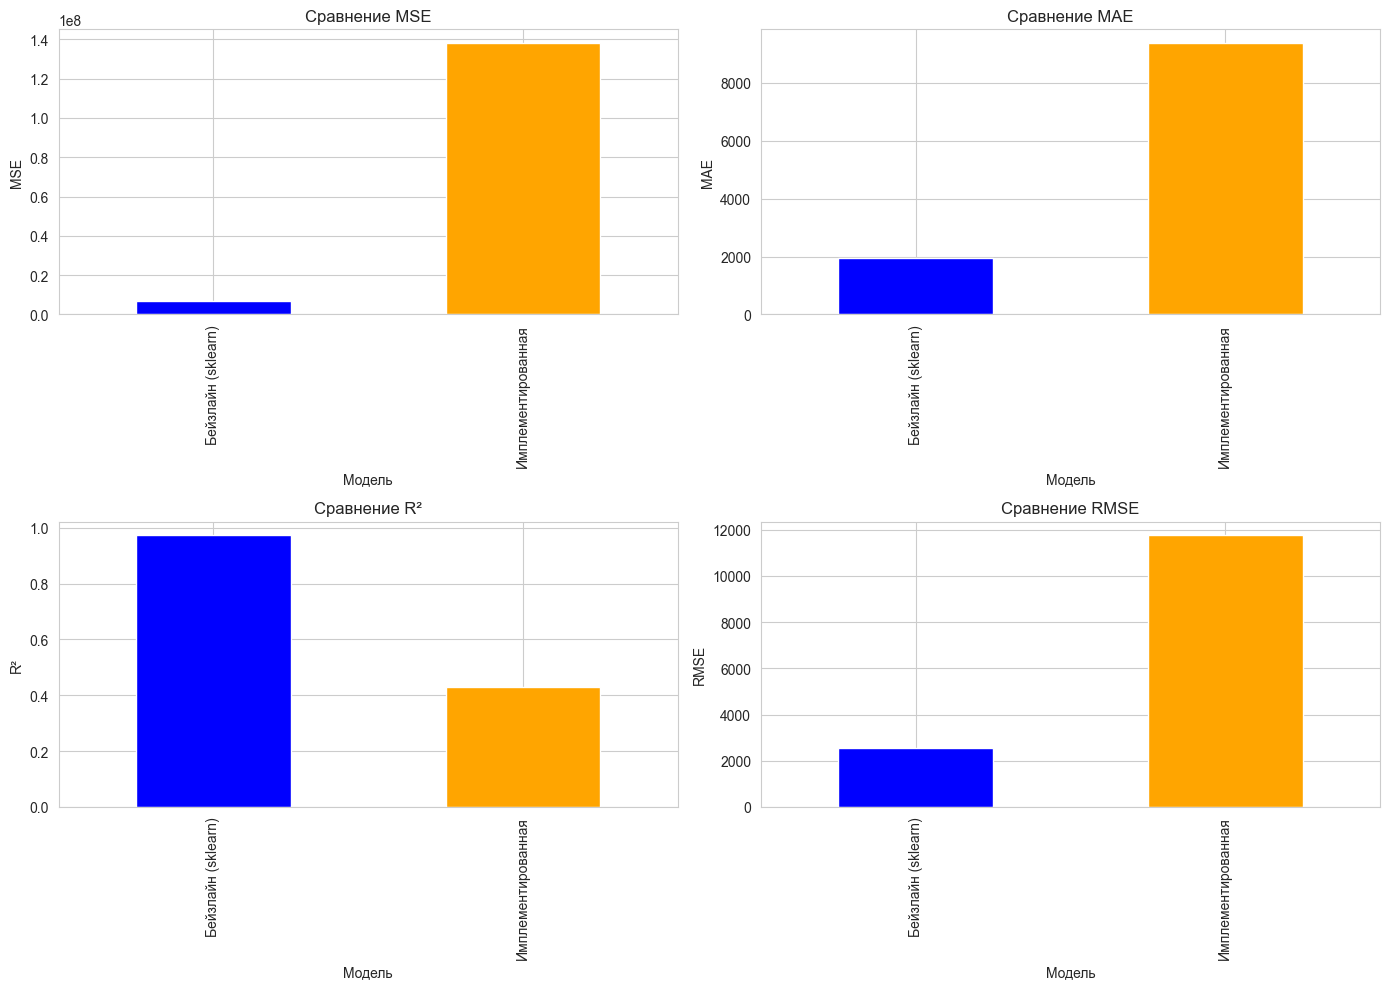

In [68]:
comparison_reg_my = pd.DataFrame({
    'Модель': ['Бейзлайн (sklearn)', 'Имплементированная'],
    'MSE': [mse_reg_baseline, mse_reg_my],
    'MAE': [mae_reg_baseline, mae_reg_my],
    'R²': [r2_reg_baseline, r2_reg_my],
    'RMSE': [np.sqrt(mse_reg_baseline), np.sqrt(mse_reg_my)]
})

print("Сравнение результатов регрессии:")
print(comparison_reg_my.to_string(index=False))

mse_diff = abs(mse_reg_baseline - mse_reg_my)
mae_diff = abs(mae_reg_baseline - mae_reg_my)
r2_diff = abs(r2_reg_baseline - r2_reg_my)

print(f"\nРазница в MSE: {mse_diff:.6f}")
print(f"Разница в MAE: {mae_diff:.6f}")
print(f"Разница в R²: {r2_diff:.6f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

comparison_reg_my.plot(x='Модель', y='MSE', kind='bar', ax=axes[0, 0], color=['blue', 'orange'])
axes[0, 0].set_title('Сравнение MSE')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend().remove()

comparison_reg_my.plot(x='Модель', y='MAE', kind='bar', ax=axes[0, 1], color=['blue', 'orange'])
axes[0, 1].set_title('Сравнение MAE')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend().remove()

comparison_reg_my.plot(x='Модель', y='R²', kind='bar', ax=axes[1, 0], color=['blue', 'orange'])
axes[1, 0].set_title('Сравнение R²')
axes[1, 0].set_ylabel('R²')
axes[1, 0].legend().remove()

comparison_reg_my.plot(x='Модель', y='RMSE', kind='bar', ax=axes[1, 1], color=['blue', 'orange'])
axes[1, 1].set_title('Сравнение RMSE')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].legend().remove()

plt.tight_layout()
plt.show()



## Добавление техник из улучшенного бейзлайна к имплементированной модели классификации


In [69]:
best_params_clf = grid_search_clf.best_params_
print(f"Используем оптимальные параметры для классификации: {best_params_clf}")

my_rf_clf_improved = MyRandomForestClassifier(
    n_estimators=best_params_clf['n_estimators'],
    max_depth=best_params_clf['max_depth'],
    min_samples_split=best_params_clf['min_samples_split'],
    min_samples_leaf=best_params_clf['min_samples_leaf'],
    max_features=best_params_clf['max_features'],
    random_state=42
)

print("Начало обучения с улучшенными параметрами...")
my_rf_clf_improved.fit(X_clf_train_scaled, y_clf_train)

y_clf_pred_my_improved = my_rf_clf_improved.predict(X_clf_test_scaled)



Используем оптимальные параметры для классификации: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Начало обучения с улучшенными параметрами...


## Результаты улучшенной имплементированной модели для классификации

In [70]:
accuracy_clf_my_improved = accuracy_score(y_clf_test, y_clf_pred_my_improved)
f1_clf_my_improved = f1_score(y_clf_test, y_clf_pred_my_improved, pos_label='>50K')

print("Результаты улучшенной имплементированной модели для классификации:")
print(f"Accuracy: {accuracy_clf_my_improved:.4f}")
print(f"F1-score: {f1_clf_my_improved:.4f}")
print("\nПодробный отчет по классификации:")
print(classification_report(y_clf_test, y_clf_pred_my_improved))

Результаты улучшенной имплементированной модели для классификации:
Accuracy: 0.8102
F1-score: 0.3739

Подробный отчет по классификации:
              precision    recall  f1-score   support

       <=50K       0.80      0.99      0.89      4945
        >50K       0.91      0.24      0.37      1568

    accuracy                           0.81      6513
   macro avg       0.86      0.61      0.63      6513
weighted avg       0.83      0.81      0.76      6513



## Добавление техник из улучшенного бейзлайна к имплементированной модели регрессии

In [71]:
best_params_reg = grid_search_reg.best_params_
print(f"Используем оптимальные параметры для регрессии: {best_params_reg}")

my_rf_reg_improved = MyRandomForestRegressor(
    n_estimators=best_params_reg['n_estimators'],
    max_depth=best_params_reg['max_depth'],
    min_samples_split=best_params_reg['min_samples_split'],
    min_samples_leaf=best_params_reg['min_samples_leaf'],
    max_features=best_params_reg['max_features'],
    random_state=42
)

print("Начало обучения с улучшенными параметрами...")
my_rf_reg_improved.fit(X_reg_train_scaled, y_reg_train)

y_reg_pred_my_improved = my_rf_reg_improved.predict(X_reg_test_scaled)

print("Предсказания завершены!")



Используем оптимальные параметры для регрессии: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Начало обучения с улучшенными параметрами...
Предсказания завершены!


## Результаты улучшенной имплементированной модели для регрессии


In [72]:
mse_reg_my_improved = mean_squared_error(y_reg_test, y_reg_pred_my_improved)
mae_reg_my_improved = mean_absolute_error(y_reg_test, y_reg_pred_my_improved)
r2_reg_my_improved = r2_score(y_reg_test, y_reg_pred_my_improved)

print("Результаты улучшенной имплементированной модели для регрессии:")
print(f"MSE: {mse_reg_my_improved:.2f}")
print(f"MAE: {mae_reg_my_improved:.2f}")
print(f"R²: {r2_reg_my_improved:.4f}")
print(f"RMSE (корень из MSE): {np.sqrt(mse_reg_my_improved):.2f}")

Результаты улучшенной имплементированной модели для регрессии:
MSE: 141737585.91
MAE: 9462.66
R²: 0.4166
RMSE (корень из MSE): 11905.36


## Сравнение улучшенной имплементированной модели с улучшенным бейзлайном

### Сравнение для классификации


Сравнение улучшенных моделей классификации:
                       Модель  Accuracy  F1-score
Улучшенный бейзлайн (sklearn)  0.852910  0.654899
Улучшенная имплементированная  0.810226  0.373860

Разница в Accuracy: 0.042684
Разница в F1-score: 0.281039


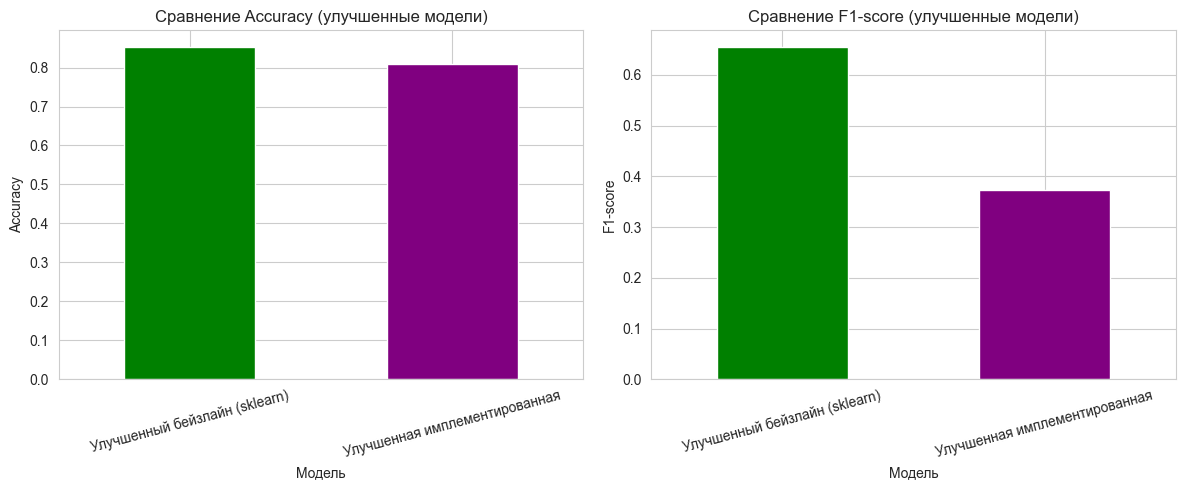

In [73]:
comparison_clf_final = pd.DataFrame({
    'Модель': ['Улучшенный бейзлайн (sklearn)', 'Улучшенная имплементированная'],
    'Accuracy': [accuracy_clf_improved, accuracy_clf_my_improved],
    'F1-score': [f1_clf_improved, f1_clf_my_improved]
})

print("Сравнение улучшенных моделей классификации:")
print(comparison_clf_final.to_string(index=False))

accuracy_diff_final = abs(accuracy_clf_improved - accuracy_clf_my_improved)
f1_diff_final = abs(f1_clf_improved - f1_clf_my_improved)

print(f"\nРазница в Accuracy: {accuracy_diff_final:.6f}")
print(f"Разница в F1-score: {f1_diff_final:.6f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
comparison_clf_final.plot(x='Модель', y='Accuracy', kind='bar', ax=axes[0], color=['green', 'purple'])
axes[0].set_title('Сравнение Accuracy (улучшенные модели)')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=15)
axes[0].legend().remove()

comparison_clf_final.plot(x='Модель', y='F1-score', kind='bar', ax=axes[1], color=['green', 'purple'])
axes[1].set_title('Сравнение F1-score (улучшенные модели)')
axes[1].set_ylabel('F1-score')
axes[1].tick_params(axis='x', rotation=15)
axes[1].legend().remove()

plt.tight_layout()
plt.show()



### Сравнение для регрессии


Сравнение улучшенных моделей регрессии:
                       Модель          MSE         MAE       R²         RMSE
Улучшенный бейзлайн (sklearn) 1.289261e+07 2566.961950 0.946931  3590.628023
Улучшенная имплементированная 1.417376e+08 9462.660617 0.416571 11905.359546

Разница в MSE: 128844976.308120
Разница в MAE: 6895.698667
Разница в R²: 0.530360


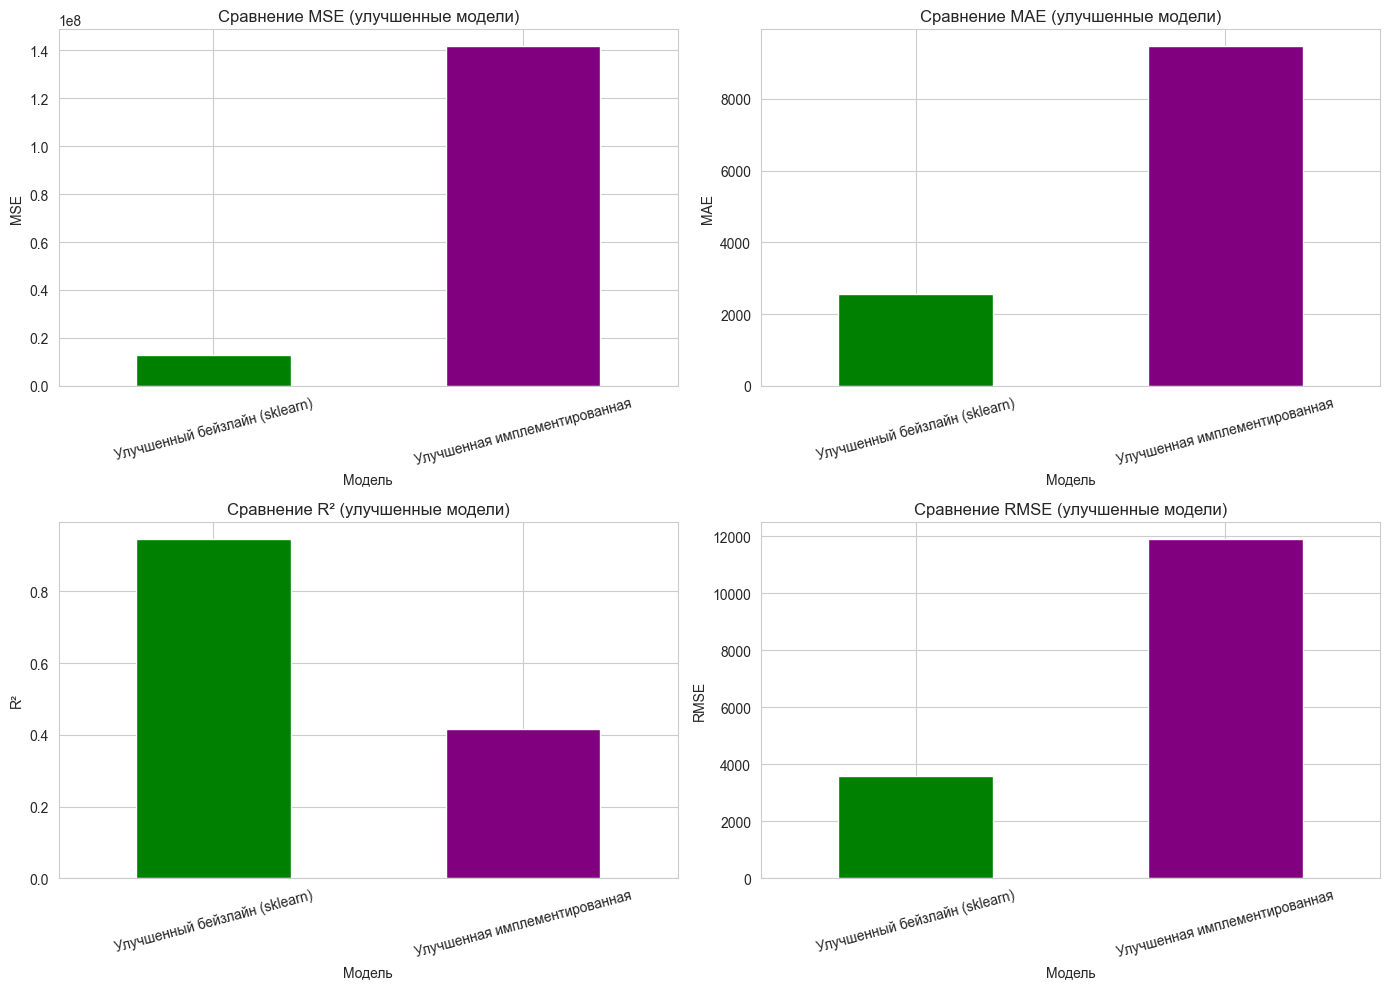

In [74]:
comparison_reg_final = pd.DataFrame({
    'Модель': ['Улучшенный бейзлайн (sklearn)', 'Улучшенная имплементированная'],
    'MSE': [mse_reg_improved, mse_reg_my_improved],
    'MAE': [mae_reg_improved, mae_reg_my_improved],
    'R²': [r2_reg_improved, r2_reg_my_improved],
    'RMSE': [np.sqrt(mse_reg_improved), np.sqrt(mse_reg_my_improved)]
})

print("Сравнение улучшенных моделей регрессии:")
print(comparison_reg_final.to_string(index=False))

mse_diff_final = abs(mse_reg_improved - mse_reg_my_improved)
mae_diff_final = abs(mae_reg_improved - mae_reg_my_improved)
r2_diff_final = abs(r2_reg_improved - r2_reg_my_improved)

print(f"\nРазница в MSE: {mse_diff_final:.6f}")
print(f"Разница в MAE: {mae_diff_final:.6f}")
print(f"Разница в R²: {r2_diff_final:.6f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

comparison_reg_final.plot(x='Модель', y='MSE', kind='bar', ax=axes[0, 0], color=['green', 'purple'])
axes[0, 0].set_title('Сравнение MSE (улучшенные модели)')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].tick_params(axis='x', rotation=15)
axes[0, 0].legend().remove()

comparison_reg_final.plot(x='Модель', y='MAE', kind='bar', ax=axes[0, 1], color=['green', 'purple'])
axes[0, 1].set_title('Сравнение MAE (улучшенные модели)')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].legend().remove()

comparison_reg_final.plot(x='Модель', y='R²', kind='bar', ax=axes[1, 0], color=['green', 'purple'])
axes[1, 0].set_title('Сравнение R² (улучшенные модели)')
axes[1, 0].set_ylabel('R²')
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].legend().remove()

comparison_reg_final.plot(x='Модель', y='RMSE', kind='bar', ax=axes[1, 1], color=['green', 'purple'])
axes[1, 1].set_title('Сравнение RMSE (улучшенные модели)')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].tick_params(axis='x', rotation=15)
axes[1, 1].legend().remove()

plt.tight_layout()
plt.show()

